# Activate GPU if available.

In [1]:
import torch

# Check for GPU availability
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using GPU: NVIDIA GeForce RTX 3080


# Setting up the dataset. It downloads and sets up a directory 'data' the first time this cell is executed.

Total number of training images in subset: 60000
Total number of testing images in subset: 2000
Loaded batch size: 64
Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


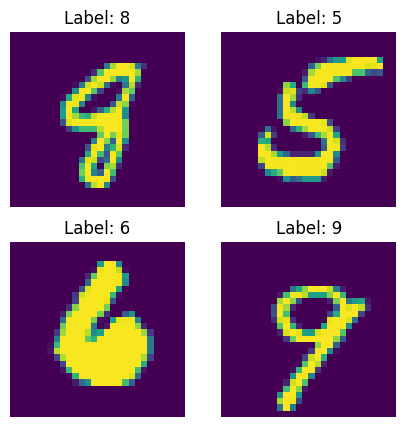

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for MNIST
transform = transforms.Compose([
    # transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor()         # Scales images to [0, 1]
])

# Load MNIST dataset with the new transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Subset the datasets to include only a set number of examples
num_samples_train = 60000  # Number of samples to include in the training subset
num_samples_test = 2000   # Number of samples to include in the testing subset

indices_train = np.random.choice(len(train_dataset), num_samples_train, replace=False)
indices_test = np.random.choice(len(test_dataset), num_samples_test, replace=False)

subset_train_dataset = Subset(train_dataset, indices_train)
subset_test_dataset = Subset(test_dataset, indices_test)

print(f"Total number of training images in subset: {len(subset_train_dataset)}")
print(f"Total number of testing images in subset: {len(subset_test_dataset)}")

# Create data loaders with subsets
train_loader = DataLoader(subset_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(subset_test_dataset, batch_size=64, shuffle=False)

# Example of accessing and plotting the first batch of images
for images, labels in train_loader:
    print(f"Loaded batch size: {images.shape[0]}")
    print(f"Images shape: {images.shape}")  # Shape of images in a batch
    print(f"Labels shape: {labels.shape}")  # Shape of labels in a batch

    # Displaying a few example images from the batch
    plt.figure(figsize=(5, 5))
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break  # Only process the first batch


# Initialize the model

In [3]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key.transpose(1, 2))
        attention = self.softmax(energy / (C // 8)**0.5)  # Added normalization factor
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(attention, proj_value.transpose(1, 2))
        out = out.view(batch_size, C, width, height)

        out = self.gamma * out + x
        return out


class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 7, 1, 0, bias=False),  # Output size: 7x7
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        )
        self.attn1 = SelfAttention(512)  # First self-attention layer
        
        self.reduce_channels = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 1, 1, 0, bias=False),  # 1x1 convolution for channel reduction
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
        self.attn2 = SelfAttention(256)  # Second self-attention layer
        
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # Upsample to 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )
        self.attn3 = SelfAttention(128)  # Third self-attention layer

        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # Upsample to 28x28
            nn.BatchNorm2d(64),
            nn.ReLU(True),
        )

        self.final = nn.Sequential(
            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),  # Maintain size 28x28
            nn.Sigmoid()
        )

    def forward(self, input):
        x = self.initial(input)
        x = self.attn1(x)  # Apply first self-attention
        x = self.reduce_channels(x)
        x = self.attn2(x)  # Apply second self-attention
        x = self.upsample1(x)
        x = self.attn3(x)  # Apply third self-attention
        x = self.upsample2(x)
        x = self.final(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.initial = nn.Sequential(
            # Reduce from 28x28 to 14x14
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.attn1 = SelfAttention(64)  # First self-attention layer

        self.middle = nn.Sequential(
            # Reduce from 14x14 to 7x7
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.attn2 = SelfAttention(128)  # Second self-attention layer

        self.main = nn.Sequential(
            # Reduce from 7x7 to 3x3
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Finally to 1x1
            nn.Conv2d(256, 1, 3, 1, 0, bias=False),  # Adjust kernel to match the final output size of 3x3
            # Remove Sigmoid here and use BCEWithLogitsLoss during training
        )

    def forward(self, input):
        x = self.initial(input)
        x = self.attn1(x)  # Apply first self-attention
        x = self.middle(x)
        x = self.attn2(x)  # Apply second self-attention
        x = self.main(x)
        return x.view(-1)


# Cell for testing the tensor shapes in layers.

In [4]:
# # Parameters
# nz = 100  # Example latent dimension size

# # Model instantiation
# generator = Generator(nz)
# discriminator = Discriminator()

# # Test with random noise
# random_noise = torch.randn(1, nz, 1, 1)
# fake_image = generator(random_noise)
# disc_output = discriminator(fake_image)

# print("Final Generated Image Size:", fake_image.size())  # Expected: [1, 1, 28, 28]
# print("Final Discriminator Output Size:", disc_output.size())  # Expected: [1]


# Training loop.

In [5]:
import torch
from torch import nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Initialize the generator and discriminator
nz = 150  # Size of z latent vector (i.e., size of generator input)
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

# Setup Loss function and Optimizers
criterion = nn.BCEWithLogitsLoss()
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Training loop
num_epochs = 50
real_label = 0.95  # Using label smoothing
fake_label = 0.0
n_critic = 2  # Number of discriminator updates per generator update

# Lists to store metrics
loss_d_values = []
loss_g_values = []
D_x_values = []
D_G_z1_values = []
D_G_z2_values = []

for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for i, (real_images, _) in loop:
        batch_size = real_images.size(0)

        # Train Discriminator
        for _ in range(n_critic):
            # Prepare real data
            real_images = real_images.to(device)
            label_real = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

            # Update discriminator on real data
            discriminator.zero_grad()
            output_real = discriminator(real_images)
            errD_real = criterion(output_real, label_real)
            errD_real.backward()
            D_x = output_real.mean().item()

            # Prepare fake data
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = generator(noise)
            label_fake = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)

            # Update discriminator on fake data
            output_fake = discriminator(fake_images.detach())
            errD_fake = criterion(output_fake, label_fake)
            errD_fake.backward()
            D_G_z1 = output_fake.mean().item()

            # Discriminator optimization step
            optimizerD.step()

        # Train Generator
        generator.zero_grad()
        label_gen = torch.full((batch_size,), real_label, dtype=torch.float, device=device)  # Generators try to deceive the discriminator
        output_gen = discriminator(fake_images)
        errG = criterion(output_gen, label_gen)
        errG.backward()
        D_G_z2 = output_gen.mean().item()

        optimizerG.step()

        # Collect metrics
        loss_d = (errD_real + errD_fake).item()
        loss_g = errG.item()

        loss_d_values.append(loss_d)
        loss_g_values.append(loss_g)
        D_x_values.append(D_x)
        D_G_z1_values.append(D_G_z1)
        D_G_z2_values.append(D_G_z2)

        # Update tqdm loop display
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss_d=loss_d, loss_g=loss_g, D_x=D_x, D_G_z1=D_G_z1, D_G_z2=D_G_z2)

    loop.close()

print("Training finished!")

# Save the collected metrics
torch.save({
    'loss_d': loss_d_values,
    'loss_g': loss_g_values,
    'D_x': D_x_values,
    'D_G_z1': D_G_z1_values,
    'D_G_z2': D_G_z2_values,
}, 'training_metrics.pth')

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Training finished!


# Visualize the training progress.

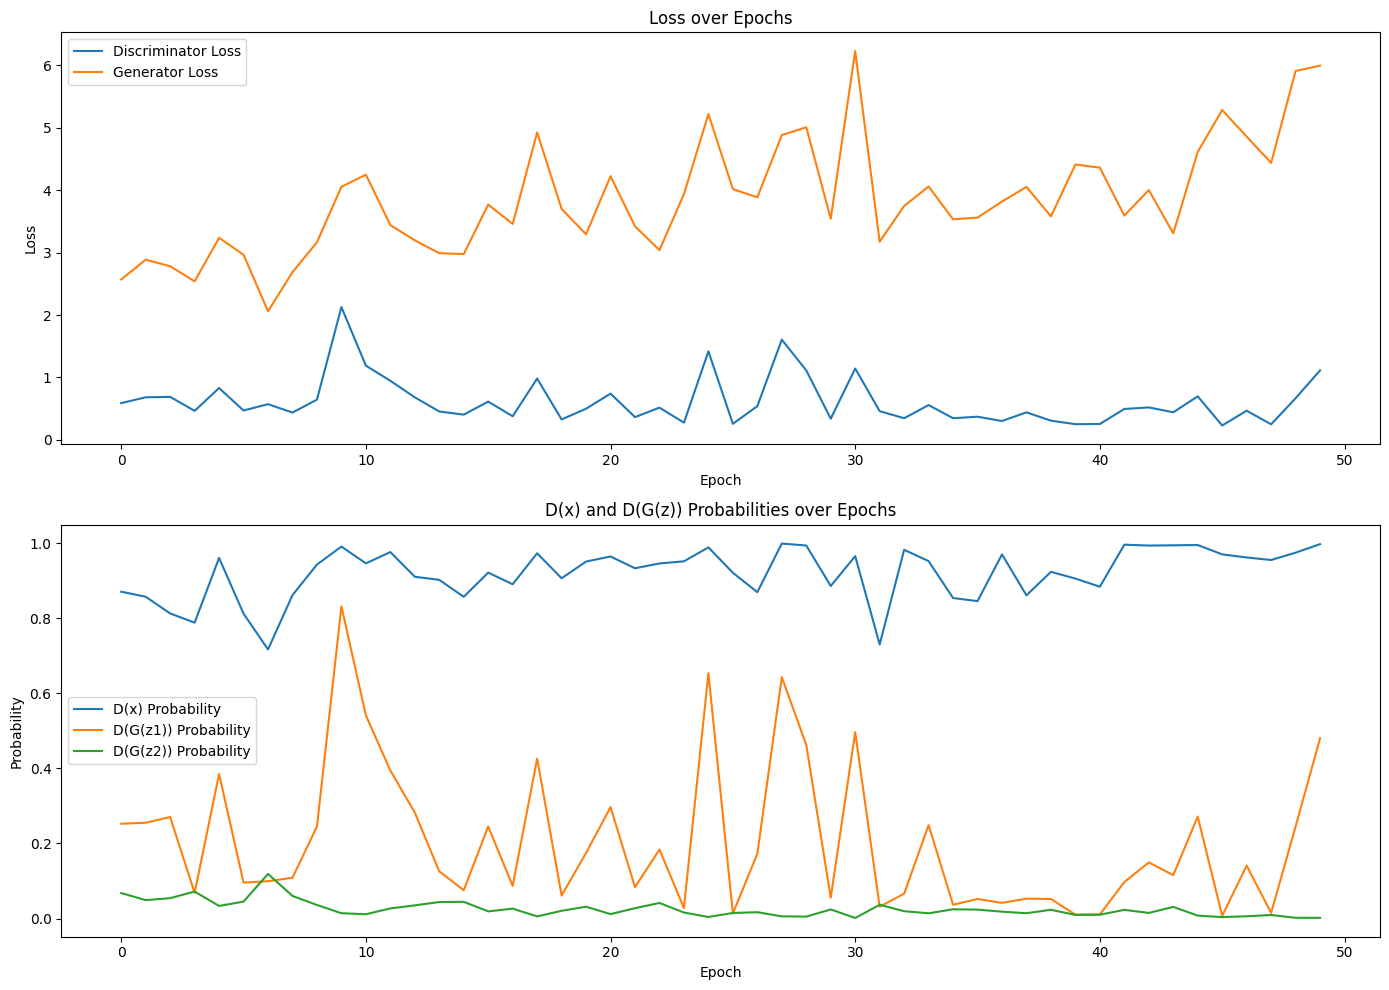

In [6]:
import torch
import matplotlib.pyplot as plt

# Load the collected metrics
metrics = torch.load('training_metrics.pth')

# Extract the metrics
loss_d_values = metrics['loss_d']
loss_g_values = metrics['loss_g']
D_x_values = metrics['D_x']
D_G_z1_values = metrics['D_G_z1']
D_G_z2_values = metrics['D_G_z2']

# Define the number of iterations per epoch (this needs to be set according to your training setup)
iterations_per_epoch = 938  # Example value, change this to match your actual setup

# Sample metrics at the end of each epoch
epoch_indices = list(range(iterations_per_epoch - 1, len(loss_d_values), iterations_per_epoch))

loss_d_epochs = [loss_d_values[i] for i in epoch_indices]
loss_g_epochs = [loss_g_values[i] for i in epoch_indices]
D_x_epochs = [D_x_values[i] for i in epoch_indices]
D_G_z1_epochs = [D_G_z1_values[i] for i in epoch_indices]
D_G_z2_epochs = [D_G_z2_values[i] for i in epoch_indices]

# Convert logits to probabilities using the sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

D_x_probs = [sigmoid(torch.tensor(logit)).item() for logit in D_x_epochs]
D_G_z1_probs = [sigmoid(torch.tensor(logit)).item() for logit in D_G_z1_epochs]
D_G_z2_probs = [sigmoid(torch.tensor(logit)).item() for logit in D_G_z2_epochs]

# Plot the metrics
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(loss_d_epochs, label='Discriminator Loss')
plt.plot(loss_g_epochs, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(2, 1, 2)
plt.plot(D_x_probs, label='D(x) Probability')
plt.plot(D_G_z1_probs, label='D(G(z1)) Probability')
plt.plot(D_G_z2_probs, label='D(G(z2)) Probability')
plt.xlabel('Epoch')
plt.ylabel('Probability')
plt.legend()
plt.title('D(x) and D(G(z)) Probabilities over Epochs')

plt.tight_layout()
plt.show()


# Plot an 8x8 array of generated numbers.

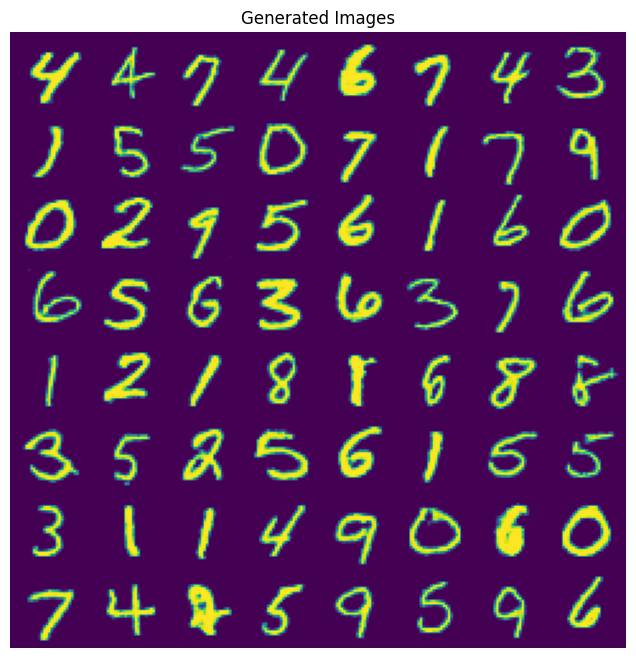

In [7]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming nz and device are defined
# nz = size of the latent vector, device = 'cuda' or 'cpu'

# After every epoch or at a set interval, generate images to see the progress
with torch.no_grad():
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    fake_images = generator(fixed_noise).detach().cpu()
    # Use make_grid to create a grid layout of images
    grid = make_grid(fake_images, padding=2, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    # Convert tensor to numpy and transpose the axes for correct image display
    grid_np = np.transpose(grid.numpy(), (1, 2, 0))
    # Convert to grayscale by averaging the color channels
    grid_gray = np.mean(grid_np, axis=2)
    # Apply the viridis colormap
    plt.imshow(grid_gray, cmap='viridis')
    plt.show()


# Plot an 8x8 array of real and generated numbers.

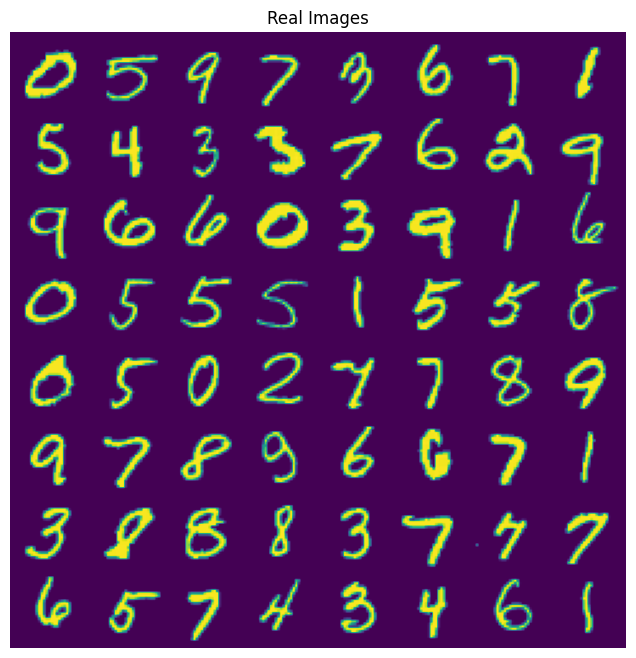

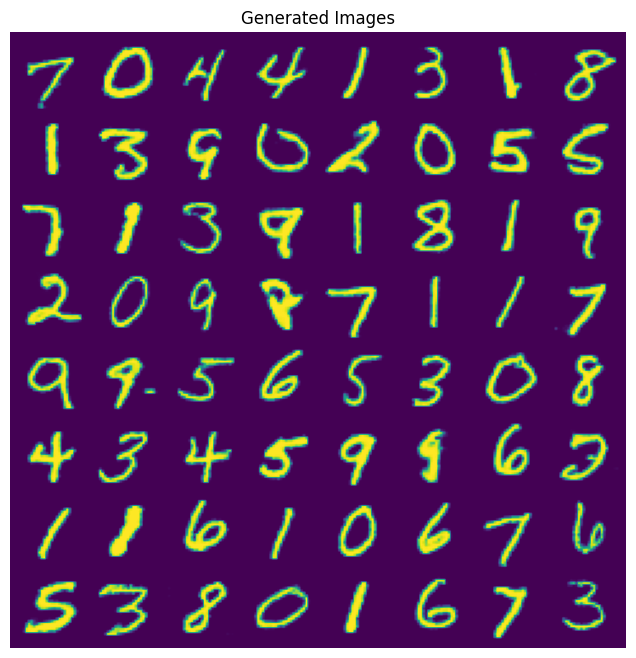

In [8]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming nz, device, and generator are already defined

# Function to display a grid of generated images
def show_generated_images():
    with torch.no_grad():
        fixed_noise = torch.randn(64, nz, 1, 1, device=device)
        fake_images = generator(fixed_noise).detach().cpu()
        grid = make_grid(fake_images, padding=2, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Generated Images")
        grid_np = np.transpose(grid.numpy(), (1, 2, 0))
        grid_gray = np.mean(grid_np, axis=2)
        plt.imshow(grid_gray, cmap='viridis')
        plt.show()

# Function to display a grid of real images
def show_real_images():
    for real_images, _ in train_loader:
        real_images = real_images.cpu()
        grid = make_grid(real_images, padding=2, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Real Images")
        grid_np = np.transpose(grid.numpy(), (1, 2, 0))
        grid_gray = np.mean(grid_np, axis=2)
        plt.imshow(grid_gray, cmap='viridis')
        plt.show()
        break  # Only process the first batch

# Display real and generated images for comparison
show_real_images()
show_generated_images()


# Save the current model.

In [9]:
# Saving the Generator
torch.save(generator.state_dict(), 'mnist64_gan_generator_state.pth')

# Saving the Discriminator
torch.save(discriminator.state_dict(), 'mnist64_gan_discriminator_state.pth')



# Load a model (make sure you run the cell with the corresponding model first or you'll get errors).

In [10]:
# # Initialize the generator and discriminator
#nz = 150  # Size of z latent vector (i.e., size of generator input)
# generator = Generator(nz).to(device)
# discriminator = Discriminator().to(device)


# # Load the state dictionaries
# generator.load_state_dict(torch.load('mnist64_gan_generator_state.pth'))  # Correct file for the generator
# discriminator.load_state_dict(torch.load('mnist64_gan_discriminator_state.pth'))  # Correct file for the discriminator

# # Set to evaluation mode for inference
# generator.eval()
# discriminator.eval()
